# Stable-Geo-Upscaler -part 2
### A Framework for Benchmarking Geospatial Super-Resolution using Tiled Diffusion Models

This project represents the second phase of a larger study on image super-resolution. While the first phase focused on general-purpose images, (e.g., from the COCO dataset), this part specifically investigates the enhancement of satellite imagery.

This initial cell installs the necessary software packages. Core deep learning libraries like diffusers, transformers, accelerate, and torch are installed to load and run the generative upscaling models. Crucially for this new phase, rasterio and rioxarray are also installed, as these are specialized libraries essential for reading and processing the geospatial raster data common to satellite images. Finally, to ensure consistent and comparable results with the project's first part, a suite of evaluation libraries—scikit-image, lpips, sewar, and image-similarity-measures—is installed to provide the SSIM, LPIPS, and FSIM quality metrics.

In [1]:
!pip install rasterio matplotlib
!pip install rioxarray contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install scikit-image lpips image-similarity-measures
!pip install diffusers transformers accelerate torch numpy rasterio pillow matplotlib sewar scikit-image pandas

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━

Following the installation, this cell imports the necessary libraries into the project's runtime. These imports are grouped by function:

Geospatial and Data Handling: rasterio, rioxarray, and pandas are imported to load, process, and manage the satellite image files and their associated data.

Image Processing and Plotting: matplotlib, numpy, PIL, and cv2 (OpenCV) provide the fundamental tools for image manipulation, numerical operations, and plotting the visual results.

AI Super-Resolution: torch is imported as the core deep learning framework. Critically, several model pipelines are imported from the diffusers library—LDMSuperResolutionPipeline, StableDiffusionUpscalePipeline, StableDiffusionImg2ImgPipeline, and StableDiffusionLatentUpscalePipeline—which represent the different AI models to be benchmarked.

Quality Evaluation: To maintain consistency with Part 1 of the study, the same evaluation functions are imported: lpips, fsim from image_similarity_measures, and structural_similarity (as ssim) from skimage. This ensures the satellite image results can be directly compared to the previous findings.

In [3]:
import rasterio
import rioxarray as rxr
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import pandas as pd
from PIL import Image
import os
import lpips
import torch
import cv2
from diffusers import StableDiffusionUpscalePipeline
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionLatentUpscalePipeline
from diffusers import LDMSuperResolutionPipeline
import matplotlib.cm as cm
from image_similarity_measures.quality_metrics import fsim
from torchvision.transforms.functional import to_tensor
import requests
from matplotlib import cm
from io import BytesIO
import time
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import seaborn as sns

2025-11-12 05:10:51.179625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762924251.408368      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762924251.472304      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/phasepack/tools.py:11: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  warnings.warn("""


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model 1: CompVis/ldm-super-resolution-4x-openimages
This cell initializes the primary upscaling and evaluation models for the experiment. Both the LDM super-resolution pipeline (CompVis/ldm-super-resolution-4x-openimages) and the LPIPS (VGG) perceptual metric are identical to those detailed and benchmarked in Part 1 of this study.

The loading process, including the use of half-precision (torch.float16) and transferring the models to the device for GPU acceleration, remains unchanged. The goal of this phase is to apply this established methodology to the new satellite image dataset and evaluate its performance."

In [5]:
model_id = "CompVis/ldm-super-resolution-4x-openimages"

ldm_pipeline = LDMSuperResolutionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)
ldm_pipeline = ldm_pipeline.to(device)

lpips_model = lpips.LPIPS(net='vgg').to(device)

model_index.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 204MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


This cell defines the core setup for Part 2. The main change from Part 1 is the focus: instead of many images, this experiment uses a single satellite image (SINGLE_IMAGE_PATH). The analysis will instead test this single image by resizing it to five different resolutions (RESOLUTIONS_TO_TEST) to see how the model handles various levels of quality. The MODEL_NAME and CSV_FILENAME are set to organize the results.

In [6]:
SINGLE_IMAGE_PATH = '/kaggle/input/for-all-model/20230123_20231225_timeseries_ERA5_ramp_demErr_Centimeters_unwrapped.tif'
RESOLUTIONS_TO_TEST = [
    (128, 128),
    (192, 192), 
    (256, 256),
    (320, 128), 
    (512, 512)
]

MODEL_NAME = "LDM-4x-OpenImages"
CSV_FILENAME = "benchmark_results_COMBINED.csv"
results_list = []

This cell defines a critical helper function, numpy_to_lpips_tensor, which is responsible for pre-processing images. The LPIPS model (like many neural networks) requires input data in a very specific format that differs from standard image arrays.

This function performs that conversion: it takes a standard NumPy image (format [H, W, C] with pixel values 0-255) and transforms it into the PyTorch tensor format that LPIPS expects (format [1, C, H, W] with pixel values normalized to the [-1, 1] range). This "normalization" step is essential for getting accurate and meaningful quality scores from the LPIPS metric.

In [7]:
def numpy_to_lpips_tensor(img_np, device):
    """
    Converts a NumPy array [H, W, C] (0-255) to a LPIPS-ready
    PyTorch tensor [1, C, H, W] (-1 to 1).
    """
    # 1. Convert to tensor and permute to [C, H, W]
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float().to(device)

    # 2. Normalize from [0, 255] to [0, 1]
    img_tensor = img_tensor / 255.0

    # 3. Normalize from [0, 1] to [-1, 1] (which LPIPS expects)
    img_tensor = (img_tensor * 2.0) - 1.0

    # 4. Add a batch dimension [1, C, H, W]
    return img_tensor.unsqueeze(0)

This cell contains the main experimental loop, which shares the same goal as Part 1—benchmarking the model—but with several key differences for the new satellite data:

**Looping**: Instead of looping over different images, this loop iterates through the RESOLUTIONS_TO_TEST list. The entire process is repeated for each resolution using the same source image.

**Data Loading**: The code now uses rasterio to open the single GeoTIFF file.

**Colormapping**: Satellite data is often single-band. A crucial new step is added to normalize this data and apply a colormap (viridis) to convert it into a 3-channel (RGB) PIL image. This is necessary to make the scientific data compatible with the diffusion models, which were trained on standard RGB images.

**Metric and Data Storage**: The loop now records the specific resolution and time for each run, in addition to the six core quality metrics (SSIM, FSIM, LPIPS for both ground-truth and low-res comparisons).

**Memory Management**: At the end of each iteration, an explicit cleanup step is run (using del and torch.cuda.empty_cache()) to clear the GPU's VRAM. This is essential to prevent out-of-memory errors when processing multiple high-resolution images in a single notebook.

In [8]:
for res_target in RESOLUTIONS_TO_TEST:
    print(f"\n--- Testing Input Resolution: {res_target} ---")

    # Open GeoTIFF and read data
    with rasterio.open(SINGLE_IMAGE_PATH) as src:
        patch_data = src.read(1)
        if src.nodata is not None:
            patch_data[patch_data == src.nodata] = np.nan

    # Normalizing data
    local_min = np.nanmin(patch_data)
    local_max = np.nanmax(patch_data)
    normalized_data = (patch_data - local_min) / (local_max - local_min + 1e-9)
    normalized_data_clean = np.nan_to_num(normalized_data, nan=0)

    # Convert to colormapped PIL Image
    cmap = cm.get_cmap('viridis')
    rgba_data = cmap(normalized_data_clean)
    rgb_data = (rgba_data[:, :, :3] * 255).astype(np.uint8)
    original_high_res_img = Image.fromarray(rgb_data)

    # Create low-res input
    low_res_input = original_high_res_img.resize(res_target, Image.Resampling.LANCZOS)
    print(f"Original High-Res: {original_high_res_img.size} -> Input Low-Res: {low_res_input.size}")

    # --- LDM ---
    print("Upscaling...")
    start_time = time.time()
    upscaled_image = ldm_pipeline(
        image=low_res_input,
        num_inference_steps=100
    ).images[0]
    end_time = time.time()
    execution_time = end_time - start_time
    target_size = upscaled_image.size
    print(f"Upscaled to: {target_size} in {execution_time:.2f}s")

    # --- Calculating Metrics ---
    original_for_comp = original_high_res_img.resize(target_size, Image.Resampling.LANCZOS)
    resized_for_comp = low_res_input.resize(target_size, Image.Resampling.LANCZOS)
    arr_upscaled = np.array(upscaled_image)
    arr_original_comp = np.array(original_for_comp)
    arr_resized_comp = np.array(resized_for_comp)

    # SSIM
    ssim_orig_vs_up = ssim(arr_original_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    ssim_res_vs_up = ssim(arr_resized_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    print(f"SSIM (Ground Truth vs Upscaled): {ssim_orig_vs_up:.4f}")
    print(f"SSIM (Low Res vs Upscaled): {ssim_res_vs_up:.4f}")

    # FSIM
    fsim_orig_vs_up = fsim(arr_original_comp, arr_upscaled)
    fsim_res_vs_up = fsim(arr_resized_comp, arr_upscaled)
    print(f"FSIM (Ground Truth vs Upscaled): {fsim_orig_vs_up:.4f}")
    print(f"FSIM (Low Res vs Upscaled): {fsim_res_vs_up:.4f}")

    # LPIPS
    tensor_upscaled = numpy_to_lpips_tensor(arr_upscaled, device)
    tensor_original_comp = numpy_to_lpips_tensor(arr_original_comp, device)
    tensor_resized_comp = numpy_to_lpips_tensor(arr_resized_comp, device)

    with torch.no_grad():
        lpips_orig_vs_up = lpips_model(tensor_original_comp, tensor_upscaled).item()
        lpips_res_vs_up = lpips_model(tensor_resized_comp, tensor_upscaled).item()

    print(f"LPIPS (Ground Truth vs Upscaled): {lpips_orig_vs_up:.4f} (Lower is better)")
    print(f"LPIPS (Low Res vs Upscaled): {lpips_res_vs_up:.4f} (Lower is better)")

    # --- Store the results ---
    results_list.append({
        'model_name': MODEL_NAME,
        'pixels': res_target[0],
        'resolution': f"{res_target[0]}x{res_target[1]}",
        'time': execution_time,
        'ssim_ground_truth_vs_upscaled': ssim_orig_vs_up,
        'ssim_low_res_vs_upscaled': ssim_res_vs_up,
        'fsim_ground_truth_vs_upscaled': fsim_orig_vs_up,
        'fsim_low_res_vs_upscaled': fsim_res_vs_up,
        'lpips_ground_truth_vs_upscaled': lpips_orig_vs_up,
        'lpips_low_res_vs_upscaled': lpips_res_vs_up
    })

    # h. Save
    output_filename = f"ldm_upscaled_{res_target[0]}x{res_target[1]}.png"
    upscaled_image.save(output_filename)
    print(f"Successfully saved test image to '{output_filename}'")

    # ---  Clear GPU Memory ---
    del upscaled_image, arr_upscaled, arr_original_comp, arr_resized_comp
    del patch_data, normalized_data, rgb_data, original_high_res_img, low_res_input
    del tensor_upscaled, tensor_original_comp, tensor_resized_comp

    if device == "cuda":
        torch.cuda.empty_cache()
        print("VRAM cache cleared.")

print("\n---  Benchmark Loop Complete ---")


--- Testing Input Resolution: (128, 128) ---


/tmp/ipykernel_19/1355845368.py:6: RuntimeWarning: invalid value encountered in greater
  patch_data = src.read(1)
/tmp/ipykernel_19/1355845368.py:6: RuntimeWarning: invalid value encountered in less
  patch_data = src.read(1)
/tmp/ipykernel_19/1355845368.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


Original High-Res: (7378, 3940) -> Input Low-Res: (128, 128)
Upscaling...


  0%|          | 0/100 [00:00<?, ?it/s]

Upscaled to: (512, 512) in 4.78s
SSIM (Ground Truth vs Upscaled): 0.8218
SSIM (Low Res vs Upscaled): 0.8438
FSIM (Ground Truth vs Upscaled): 0.4994
FSIM (Low Res vs Upscaled): 0.5133
LPIPS (Ground Truth vs Upscaled): 0.1671 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2204 (Lower is better)
Successfully saved test image to 'ldm_upscaled_128x128.png'
VRAM cache cleared.

--- Testing Input Resolution: (192, 192) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (192, 192)
Upscaling...


  0%|          | 0/100 [00:00<?, ?it/s]

Upscaled to: (768, 768) in 7.71s
SSIM (Ground Truth vs Upscaled): 0.8319
SSIM (Low Res vs Upscaled): 0.8568
FSIM (Ground Truth vs Upscaled): 0.4678
FSIM (Low Res vs Upscaled): 0.4846
LPIPS (Ground Truth vs Upscaled): 0.2048 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2642 (Lower is better)
Successfully saved test image to 'ldm_upscaled_192x192.png'
VRAM cache cleared.

--- Testing Input Resolution: (256, 256) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (256, 256)
Upscaling...


  0%|          | 0/100 [00:00<?, ?it/s]

Upscaled to: (1024, 1024) in 13.69s
SSIM (Ground Truth vs Upscaled): 0.8399
SSIM (Low Res vs Upscaled): 0.8701
FSIM (Ground Truth vs Upscaled): 0.4596
FSIM (Low Res vs Upscaled): 0.4796
LPIPS (Ground Truth vs Upscaled): 0.2005 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2470 (Lower is better)
Successfully saved test image to 'ldm_upscaled_256x256.png'
VRAM cache cleared.

--- Testing Input Resolution: (320, 128) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (320, 128)
Upscaling...


  0%|          | 0/100 [00:00<?, ?it/s]

Upscaled to: (1280, 512) in 8.87s
SSIM (Ground Truth vs Upscaled): 0.8288
SSIM (Low Res vs Upscaled): 0.8499
FSIM (Ground Truth vs Upscaled): 0.4767
FSIM (Low Res vs Upscaled): 0.4889
LPIPS (Ground Truth vs Upscaled): 0.1863 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2416 (Lower is better)
Successfully saved test image to 'ldm_upscaled_320x128.png'
VRAM cache cleared.

--- Testing Input Resolution: (512, 512) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (512, 512)
Upscaling...


  0%|          | 0/100 [00:00<?, ?it/s]

Upscaled to: (2048, 2048) in 71.44s
SSIM (Ground Truth vs Upscaled): 0.8283
SSIM (Low Res vs Upscaled): 0.8686
FSIM (Ground Truth vs Upscaled): 0.4346
FSIM (Low Res vs Upscaled): 0.4508
LPIPS (Ground Truth vs Upscaled): 0.2254 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2701 (Lower is better)
Successfully saved test image to 'ldm_upscaled_512x512.png'
VRAM cache cleared.

---  Benchmark Loop Complete ---


This cell uses the exact same data-saving logic as in Part 1. After the benchmark loop finishes, it converts the collected results_list into a pandas DataFrame. It then appends this DataFrame to the master CSV_FILENAME (or creates the file if it's the very first run). This "append" logic is the key mechanism that allows the results from this model to be saved in the same file as all other model tests, building the complete benchmark_results_COMBINED.csv file for final analysis.

In [9]:
if results_list:
    df_results = pd.DataFrame(results_list)
    # print(df_results.to_string())

    file_exists = os.path.exists(CSV_FILENAME)

    if file_exists:
        print(f"Appending results to existing file: {CSV_FILENAME}")
        df_results.to_csv(CSV_FILENAME, mode='a', header=False, index=False)
    else:
        print(f"Creating new file: {CSV_FILENAME}")
        df_results.to_csv(CSV_FILENAME, mode='w', header=True, index=False)

Creating new file: benchmark_results_COMBINED.csv


## Model 2: stabilityai/stable-diffusion-x4-upscaler
It's loaded from the Hub using its identifier ("stabilityai/stable-diffusion-x4-upscaler"). A key difference for this specific model is the use of the variant="fp16" argument, which explicitly pulls a pre-quantized half-precision version of the model, in addition to setting the torch_dtype.

This pipeline is also moved to the active device, making it ready for the same benchmarking loop that was applied to the LDM model.

In [10]:
model_id = "stabilityai/stable-diffusion-x4-upscaler"

sd_pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, variant="fp16", torch_dtype=torch.float16
)
sd_pipeline = sd_pipeline.to(device)

model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/947M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/111M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The MODEL_NAME variable is set here purely for data logging. It ensures that when the results are saved to the master CSV file, each row is correctly labeled as belonging to the "SD-x4-Upscaler" benchmark run.

The prompt and negative_prompt are separate, functional parameters that are required by this specific model pipeline to guide the upscaling process.

In [11]:
MODEL_NAME = "SD-x4-Upscaler"

prompt = "a high-resolution false-color satellite image, 4x upscale, sharp details, photorealistic, gis, remote sensing, viridis colormap"
negative_prompt = "blurry, low quality, grainy, noise, clouds, haze, artistic, cartoon, painting, jpg artifact"


This cell runs the benchmark loop for the Stable Diffusion x4 Upscaler, and it's nearly identical in structure to the LDM model's loop.

It iterates through the RESOLUTIONS_TO_TEST, loads and colormaps the same satellite image, and calculates the exact same six quality metrics.

The only functional difference is in the upscaling step. Instead of the LDM pipeline, this cell calls the sd_pipeline, passing in the prompt, negative_prompt, and guidance_scale parameters that were defined in the previous cell. The rest of the process—metric calculation, data logging, and memory cleanup—remains the same.

In [12]:
for res_target in RESOLUTIONS_TO_TEST:
    print(f"\n--- Testing Input Resolution: {res_target} ---")
    
    #  Open GeoTIFF and read data
    with rasterio.open(SINGLE_IMAGE_PATH) as src:
        patch_data = src.read(1)
        if src.nodata is not None:
            patch_data[patch_data == src.nodata] = np.nan
    
    # Normalize scientific data
    local_min = np.nanmin(patch_data)
    local_max = np.nanmax(patch_data)
    normalized_data = (patch_data - local_min) / (local_max - local_min + 1e-9)
    normalized_data_clean = np.nan_to_num(normalized_data, nan=0)
        
    # Convert to colormapped PIL Image
    cmap = cm.get_cmap('viridis')
    rgba_data = cmap(normalized_data_clean)
    rgb_data = (rgba_data[:, :, :3] * 255).astype(np.uint8)
    original_high_res_img = Image.fromarray(rgb_data)

    # Create low-res input
    low_res_input = original_high_res_img.resize(res_target, Image.Resampling.LANCZOS)
    print(f"Original High-Res: {original_high_res_img.size} -> Input Low-Res: {low_res_input.size}")
        
    start_time = time.time()
    upscaled_image = sd_pipeline(
        prompt=prompt,
        image=low_res_input,
        negative_prompt=negative_prompt,
        guidance_scale=1.0
    ).images[0]
    end_time = time.time()
    execution_time = end_time - start_time
    target_size = upscaled_image.size
    print(f"Upscaled to: {target_size} in {execution_time:.2f}s")

    # --- Calculating Metrics ---
    original_for_comp = original_high_res_img.resize(target_size, Image.Resampling.LANCZOS)
    resized_for_comp = low_res_input.resize(target_size, Image.Resampling.LANCZOS)
    arr_upscaled = np.array(upscaled_image)
    arr_original_comp = np.array(original_for_comp)
    arr_resized_comp = np.array(resized_for_comp)
    
    # SSIM
    ssim_orig_vs_up = ssim(arr_original_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    ssim_res_vs_up = ssim(arr_resized_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    print(f"SSIM (Ground Truth vs Upscaled): {ssim_orig_vs_up:.4f}")
    print(f"SSIM (Low Res vs Upscaled): {ssim_res_vs_up:.4f}")

    # FSIM
    fsim_orig_vs_up = fsim(arr_original_comp, arr_upscaled)
    fsim_res_vs_up = fsim(arr_resized_comp, arr_upscaled)
    print(f"FSIM (Ground Truth vs Upscaled): {fsim_orig_vs_up:.4f}")
    print(f"FSIM (Low Res vs Upscaled): {fsim_res_vs_up:.4f}")

    # LPIPS
    tensor_upscaled = numpy_to_lpips_tensor(arr_upscaled, device)
    tensor_original_comp = numpy_to_lpips_tensor(arr_original_comp, device)
    tensor_resized_comp = numpy_to_lpips_tensor(arr_resized_comp, device)
    
    with torch.no_grad():
        lpips_orig_vs_up = lpips_model(tensor_original_comp, tensor_upscaled).item()
        lpips_res_vs_up = lpips_model(tensor_resized_comp, tensor_upscaled).item()
        
    print(f"LPIPS (Ground Truth vs Upscaled): {lpips_orig_vs_up:.4f} (Lower is better)")
    print(f"LPIPS (Low Res vs Upscaled): {lpips_res_vs_up:.4f} (Lower is better)")

    # --- Store the results ---
    results_list.append({
        'model_name': MODEL_NAME,  # Use variable from Cell 4
        'pixels': res_target[0], 
        'resolution': f"{res_target[0]}x{res_target[1]}",
        'time': execution_time,
        'ssim_ground_truth_vs_upscaled': ssim_orig_vs_up,
        'ssim_low_res_vs_upscaled': ssim_res_vs_up,
        'fsim_ground_truth_vs_upscaled': fsim_orig_vs_up,
        'fsim_low_res_vs_upscaled': fsim_res_vs_up,
        'lpips_ground_truth_vs_upscaled': lpips_orig_vs_up,
        'lpips_low_res_vs_upscaled': lpips_res_vs_up
    })

    # Save
    output_filename = f"sd_upscaled_{res_target[0]}x{res_target[1]}.png"
    upscaled_image.save(output_filename)
    
    # ---  Clear GPU Memory ---
    del upscaled_image, arr_upscaled, arr_original_comp, arr_resized_comp
    del patch_data, normalized_data, rgb_data, original_high_res_img, low_res_input
    del tensor_upscaled, tensor_original_comp, tensor_resized_comp 
    
    if device == "cuda":
        torch.cuda.empty_cache()

print("\n---  Benchmark Loop Complete ---")


--- Testing Input Resolution: (128, 128) ---


/tmp/ipykernel_19/2406673994.py:6: RuntimeWarning: invalid value encountered in greater
  patch_data = src.read(1)
/tmp/ipykernel_19/2406673994.py:6: RuntimeWarning: invalid value encountered in less
  patch_data = src.read(1)
/tmp/ipykernel_19/2406673994.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


Original High-Res: (7378, 3940) -> Input Low-Res: (128, 128)


  0%|          | 0/75 [00:00<?, ?it/s]

Upscaled to: (512, 512) in 8.10s
SSIM (Ground Truth vs Upscaled): 0.7298
SSIM (Low Res vs Upscaled): 0.7943
FSIM (Ground Truth vs Upscaled): 0.4780
FSIM (Low Res vs Upscaled): 0.5446
LPIPS (Ground Truth vs Upscaled): 0.3210 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2652 (Lower is better)

--- Testing Input Resolution: (192, 192) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (192, 192)


  0%|          | 0/75 [00:00<?, ?it/s]

Upscaled to: (768, 768) in 17.79s
SSIM (Ground Truth vs Upscaled): 0.6962
SSIM (Low Res vs Upscaled): 0.7456
FSIM (Ground Truth vs Upscaled): 0.4157
FSIM (Low Res vs Upscaled): 0.4485
LPIPS (Ground Truth vs Upscaled): 0.3768 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.3481 (Lower is better)

--- Testing Input Resolution: (256, 256) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (256, 256)


  0%|          | 0/75 [00:00<?, ?it/s]

Upscaled to: (1024, 1024) in 32.62s
SSIM (Ground Truth vs Upscaled): 0.7230
SSIM (Low Res vs Upscaled): 0.7809
FSIM (Ground Truth vs Upscaled): 0.4033
FSIM (Low Res vs Upscaled): 0.4468
LPIPS (Ground Truth vs Upscaled): 0.3753 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.3223 (Lower is better)

--- Testing Input Resolution: (320, 128) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (320, 128)


  0%|          | 0/75 [00:00<?, ?it/s]

Upscaled to: (1280, 512) in 18.86s
SSIM (Ground Truth vs Upscaled): 0.7344
SSIM (Low Res vs Upscaled): 0.7853
FSIM (Ground Truth vs Upscaled): 0.4523
FSIM (Low Res vs Upscaled): 0.4927
LPIPS (Ground Truth vs Upscaled): 0.3371 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.2949 (Lower is better)

--- Testing Input Resolution: (512, 512) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (512, 512)


  0%|          | 0/75 [00:00<?, ?it/s]

Upscaled to: (2048, 2048) in 145.82s
SSIM (Ground Truth vs Upscaled): 0.6970
SSIM (Low Res vs Upscaled): 0.7635
FSIM (Ground Truth vs Upscaled): 0.3771
FSIM (Low Res vs Upscaled): 0.4082
LPIPS (Ground Truth vs Upscaled): 0.3910 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.3373 (Lower is better)

---  Benchmark Loop Complete ---


This cell executes the same data-saving logic used for the previous model. It converts the results_list—which now contains the performance metrics for the SD-x4-Upscaler—into a pandas DataFrame. It then appends these new results to the master CSV_FILENAME, allowing the data from this second model to be added to the same file as the LDM model's results for final analysis.m

In [13]:
if results_list:
    df_results = pd.DataFrame(results_list)
    #print(df_results.to_string())

    file_exists = os.path.exists(CSV_FILENAME)

    if file_exists:
        df_results.to_csv(CSV_FILENAME, mode='a', header=False, index=False)
    else:
        df_results.to_csv(CSV_FILENAME, mode='w', header=True, index=False)


## Model 3: stabilityai/sd-x2-latent-upscaler

This cell initializes the third and final model for the experiment, the Stable Diffusion x2 Latent Upscaler.

It's loaded from the Hub using its identifier ("stabilityai/sd-x2-latent-upscaler") and, consistent with the other models, is configured to use half-precision (torch.float16) for memory and speed efficiency.

This latent_pipeline is then moved to the device, making it ready for the final round of benchmarking using the same process as the previous two models.

In [14]:
model_id = "stabilityai/sd-x2-latent-upscaler"

latent_pipeline = StableDiffusionLatentUpscalePipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)
latent_pipeline = latent_pipeline.to(device)

model_index.json:   0%|          | 0.00/408 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

This cell sets up the parameters for the third model, the "SD-x2-Latent-4x".

As with the previous models, the MODEL_NAME variable is updated to "SD-x2-Latent-4x" to ensure the results are correctly tagged in the master CSV file.

This pipeline also requires text guidance, but the parameters are different from the x4 upscaler. A more generic prompt and negative_prompt are defined, and specific GUIDANCE_SCALE and NUM_INFERENCE_STEPS (20, which is much lower than the LDM model) are set. These parameters are unique to this model and will control its specific image generation behavior during the benchmark.

In [15]:
MODEL_NAME = "SD-x2-Latent-4x"

prompt = "high quality, 4k, uhd, sharp details, photorealistic"
negative_prompt = "blurry, low quality, grainy, noise, cartoon"
GUIDANCE_SCALE = 7.5
NUM_INFERENCE_STEPS = 20

This cell runs the benchmark for the third model, the Latent x2 Upscaler, and it contains one critical difference from the previous loops.

Since this pipeline is a 2x upscaler, it must be run twice to achieve the 4x upscaling required to compare it with the other models.

The loop first runs the pipeline on the low_res_input to create an intermediate_image (2x). It then immediately runs the same pipeline again on that intermediate_image to produce the final upscaled_image (total 4x).

The execution_time is measured to include both of these upscaling steps, ensuring the recorded time is a fair "apples-to-apples" comparison against the single-step 4x models. The rest of the process—data loading, colormapping, metric calculation, and saving—remains identical to the previous benchmarks.

In [16]:
for res_target in RESOLUTIONS_TO_TEST:
    print(f"\n--- Testing Input Resolution: {res_target} ---")

    #  Open GeoTIFF and read data
    with rasterio.open(SINGLE_IMAGE_PATH) as src:
        patch_data = src.read(1)
        if src.nodata is not None:
            patch_data[patch_data == src.nodata] = np.nan

    #  Normalize scientific data
    local_min = np.nanmin(patch_data)
    local_max = np.nanmax(patch_data)
    normalized_data = (patch_data - local_min) / (local_max - local_min + 1e-9)
    normalized_data_clean = np.nan_to_num(normalized_data, nan=0)

    #  Convert to colormapped PIL Image
    cmap = cm.get_cmap('viridis')
    rgba_data = cmap(normalized_data_clean)
    rgb_data = (rgba_data[:, :, :3] * 255).astype(np.uint8)
    original_high_res_img = Image.fromarray(rgb_data)

    #  Create low-res input
    low_res_input = original_high_res_img.resize(res_target, Image.Resampling.LANCZOS)
    print(f"Original High-Res: {original_high_res_img.size} -> Input Low-Res: {low_res_input.size}")


    start_time = time.time()

    # 2x Upscale
    intermediate_image = latent_pipeline(
        prompt=prompt,
        image=low_res_input,
        negative_prompt=negative_prompt,
        guidance_scale=GUIDANCE_SCALE,
        num_inference_steps=NUM_INFERENCE_STEPS
    ).images[0]

    print(f"Upscaling (Step 2: 4x)... (Input size: {intermediate_image.size})")

    #  4x Upscale(using the intermediate image)
    upscaled_image = latent_pipeline(
        prompt=prompt,
        image=intermediate_image, 
        negative_prompt=negative_prompt,
        guidance_scale=GUIDANCE_SCALE,
        num_inference_steps=NUM_INFERENCE_STEPS
    ).images[0]

    end_time = time.time() # Stop timer after second step
    execution_time = end_time - start_time # Total time

    target_size = upscaled_image.size
    print(f"Final 4x Upscaled to: {target_size} in {execution_time:.2f}s")

    # ---  Calculate Metrics ---
    original_for_comp = original_high_res_img.resize(target_size, Image.Resampling.LANCZOS)
    resized_for_comp = low_res_input.resize(target_size, Image.Resampling.LANCZOS)
    arr_upscaled = np.array(upscaled_image)
    arr_original_comp = np.array(original_for_comp)
    arr_resized_comp = np.array(resized_for_comp)

    # SSIM
    ssim_orig_vs_up = ssim(arr_original_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    ssim_res_vs_up = ssim(arr_resized_comp, arr_upscaled, multichannel=True, data_range=255, channel_axis=2, win_size=7)
    print(f"SSIM (Ground Truth vs Upscaled): {ssim_orig_vs_up:.4f}")
    print(f"SSIM (Low Res vs Upscaled): {ssim_res_vs_up:.4f}")

    # FSIM
    fsim_orig_vs_up = fsim(arr_original_comp, arr_upscaled)
    fsim_res_vs_up = fsim(arr_resized_comp, arr_upscaled)
    print(f"FSIM (Ground Truth vs Upscaled): {fsim_orig_vs_up:.4f}")
    print(f"FSIM (Low Res vs Upscaled): {fsim_res_vs_up:.4f}")

    # LPIPS
    tensor_upscaled = numpy_to_lpips_tensor(arr_upscaled, device)
    tensor_original_comp = numpy_to_lpips_tensor(arr_original_comp, device)
    tensor_resized_comp = numpy_to_lpips_tensor(arr_resized_comp, device)

    with torch.no_grad():
        lpips_orig_vs_up = lpips_model(tensor_original_comp, tensor_upscaled).item()
        lpips_res_vs_up = lpips_model(tensor_resized_comp, tensor_upscaled).item()

    print(f"LPIPS (Ground Truth vs Upscaled): {lpips_orig_vs_up:.4f} (Lower is better)")
    print(f"LPIPS (Low Res vs Upscaled): {lpips_res_vs_up:.4f} (Lower is better)")

    # ---  Store the results ---
    results_list.append({
        'model_name': MODEL_NAME,  # Use variable from Cell 4
        'pixels': res_target[0],
        'resolution': f"{res_target[0]}x{res_target[1]}",
        'time': execution_time,
        'ssim_ground_truth_vs_upscaled': ssim_orig_vs_up,
        'ssim_low_res_vs_upscaled': ssim_res_vs_up,
        'fsim_ground_truth_vs_upscaled': fsim_orig_vs_up,
        'fsim_low_res_vs_upscaled': fsim_res_vs_up,
        'lpips_ground_truth_vs_upscaled': lpips_orig_vs_up,
        'lpips_low_res_vs_upscaled': lpips_res_vs_up
    })

    #  Save
    output_filename = f"latent_upscaled_{res_target[0]}x{res_target[1]}.png" # <-- CHANGED
    upscaled_image.save(output_filename)
    print(f"Successfully saved test image to '{output_filename}'")

    # ---  Clear GPU Memory ---
    del upscaled_image, intermediate_image, arr_upscaled, arr_original_comp, arr_resized_comp
    del patch_data, normalized_data, rgb_data, original_high_res_img, low_res_input
    del tensor_upscaled, tensor_original_comp, tensor_resized_comp

    if device == "cuda":
        torch.cuda.empty_cache()
        print("VRAM cache cleared.")

print("\n--- Benchmark Loop Complete ---")


--- Testing Input Resolution: (128, 128) ---


/tmp/ipykernel_19/1760321194.py:6: RuntimeWarning: invalid value encountered in greater
  patch_data = src.read(1)
/tmp/ipykernel_19/1760321194.py:6: RuntimeWarning: invalid value encountered in less
  patch_data = src.read(1)
/tmp/ipykernel_19/1760321194.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


Original High-Res: (7378, 3940) -> Input Low-Res: (128, 128)


  0%|          | 0/20 [00:00<?, ?it/s]

Upscaling (Step 2: 4x)... (Input size: (256, 256))


  0%|          | 0/20 [00:00<?, ?it/s]

Final 4x Upscaled to: (512, 512) in 2.98s
SSIM (Ground Truth vs Upscaled): 0.4447
SSIM (Low Res vs Upscaled): 0.4615
FSIM (Ground Truth vs Upscaled): 0.3117
FSIM (Low Res vs Upscaled): 0.3067
LPIPS (Ground Truth vs Upscaled): 0.4788 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.5055 (Lower is better)
Successfully saved test image to 'latent_upscaled_128x128.png'
VRAM cache cleared.

--- Testing Input Resolution: (192, 192) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (192, 192)


  0%|          | 0/20 [00:00<?, ?it/s]

Upscaling (Step 2: 4x)... (Input size: (384, 384))


  0%|          | 0/20 [00:00<?, ?it/s]

Final 4x Upscaled to: (768, 768) in 4.88s
SSIM (Ground Truth vs Upscaled): 0.5852
SSIM (Low Res vs Upscaled): 0.5997
FSIM (Ground Truth vs Upscaled): 0.3472
FSIM (Low Res vs Upscaled): 0.3393
LPIPS (Ground Truth vs Upscaled): 0.4006 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.4367 (Lower is better)
Successfully saved test image to 'latent_upscaled_192x192.png'
VRAM cache cleared.

--- Testing Input Resolution: (256, 256) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (256, 256)


  0%|          | 0/20 [00:00<?, ?it/s]

Upscaling (Step 2: 4x)... (Input size: (512, 512))


  0%|          | 0/20 [00:00<?, ?it/s]

Final 4x Upscaled to: (1024, 1024) in 7.39s
SSIM (Ground Truth vs Upscaled): 0.5512
SSIM (Low Res vs Upscaled): 0.5669
FSIM (Ground Truth vs Upscaled): 0.3020
FSIM (Low Res vs Upscaled): 0.2908
LPIPS (Ground Truth vs Upscaled): 0.4452 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.4860 (Lower is better)
Successfully saved test image to 'latent_upscaled_256x256.png'
VRAM cache cleared.

--- Testing Input Resolution: (320, 128) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (320, 128)


  0%|          | 0/20 [00:00<?, ?it/s]

Upscaling (Step 2: 4x)... (Input size: (640, 256))


  0%|          | 0/20 [00:00<?, ?it/s]

Final 4x Upscaled to: (1280, 512) in 5.36s
SSIM (Ground Truth vs Upscaled): 0.6097
SSIM (Low Res vs Upscaled): 0.6216
FSIM (Ground Truth vs Upscaled): 0.3410
FSIM (Low Res vs Upscaled): 0.3306
LPIPS (Ground Truth vs Upscaled): 0.4227 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.4643 (Lower is better)
Successfully saved test image to 'latent_upscaled_320x128.png'
VRAM cache cleared.

--- Testing Input Resolution: (512, 512) ---
Original High-Res: (7378, 3940) -> Input Low-Res: (512, 512)


  0%|          | 0/20 [00:00<?, ?it/s]

Upscaling (Step 2: 4x)... (Input size: (1024, 1024))


  0%|          | 0/20 [00:00<?, ?it/s]

Final 4x Upscaled to: (2048, 2048) in 31.43s
SSIM (Ground Truth vs Upscaled): 0.5616
SSIM (Low Res vs Upscaled): 0.5803
FSIM (Ground Truth vs Upscaled): 0.2930
FSIM (Low Res vs Upscaled): 0.2744
LPIPS (Ground Truth vs Upscaled): 0.4522 (Lower is better)
LPIPS (Low Res vs Upscaled): 0.4947 (Lower is better)
Successfully saved test image to 'latent_upscaled_512x512.png'
VRAM cache cleared.

--- Benchmark Loop Complete ---


In [17]:
if results_list:
    df_results = pd.DataFrame(results_list)
    #print(df_results.to_string())

    file_exists = os.path.exists(CSV_FILENAME)

    if file_exists:
        df_results.to_csv(CSV_FILENAME, mode='a', header=False, index=False)
    else:
        df_results.to_csv(CSV_FILENAME, mode='w', header=True, index=False)


## Analysis

This cell transitions from data collection to data analysis and visualization, using the master CSV file saved from all previous steps.

The code first loads the complete benchmark_results_COMBINED.csv file into a pandas DataFrame. It then proceeds to generate the three key visualizations for the project's final report:

Graph 1 & 2: The code "melts" the DataFrame to plot the metrics (SSIM, FSIM, LPIPS) over the different pixels (resolutions). It uses seaborn.FacetGrid to create two sets of subplots:

One set for the "Low Res vs. Upscaled" scores.

One set for the "Ground Truth vs. Upscaled" scores. This allows for a detailed, side-by-side comparison of how each model's performance changes as the input quality changes.

Graph 3: The code creates a summary comparison. It first calculates the average "Ground Truth vs. Upscaled" score for each model. It then generates a figure with three bar charts, one for each metric (SSIM, FSIM, LPIPS), directly comparing the average performance of the three models to determine which one performed best overall.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

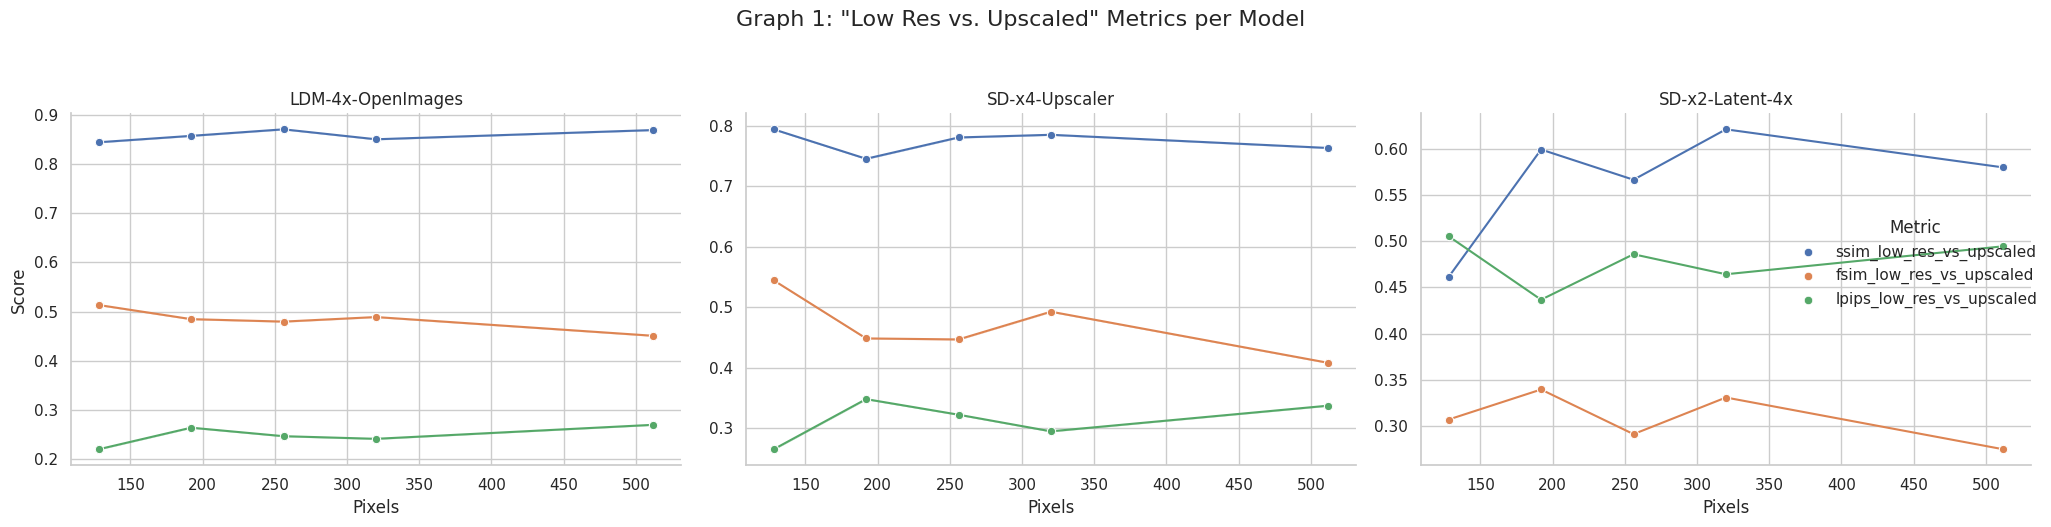

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

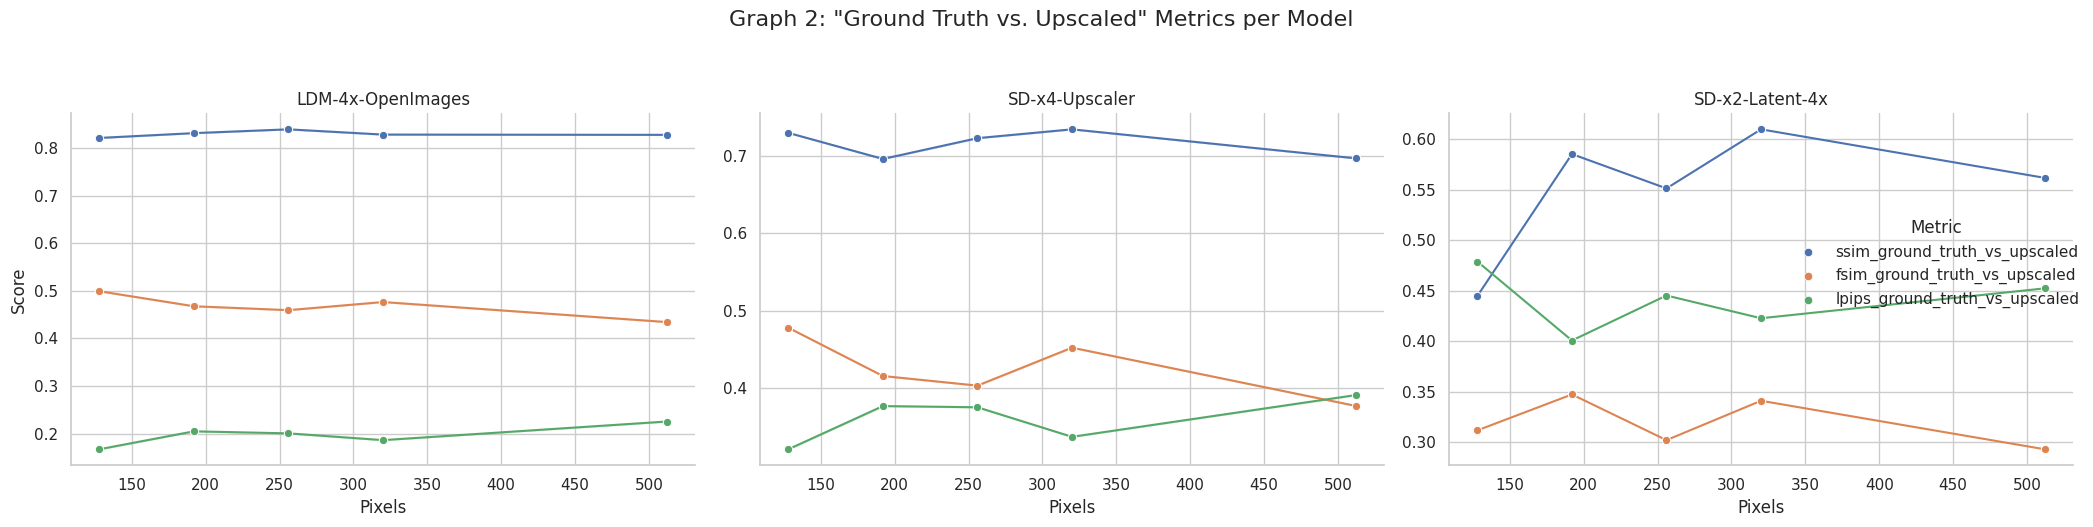

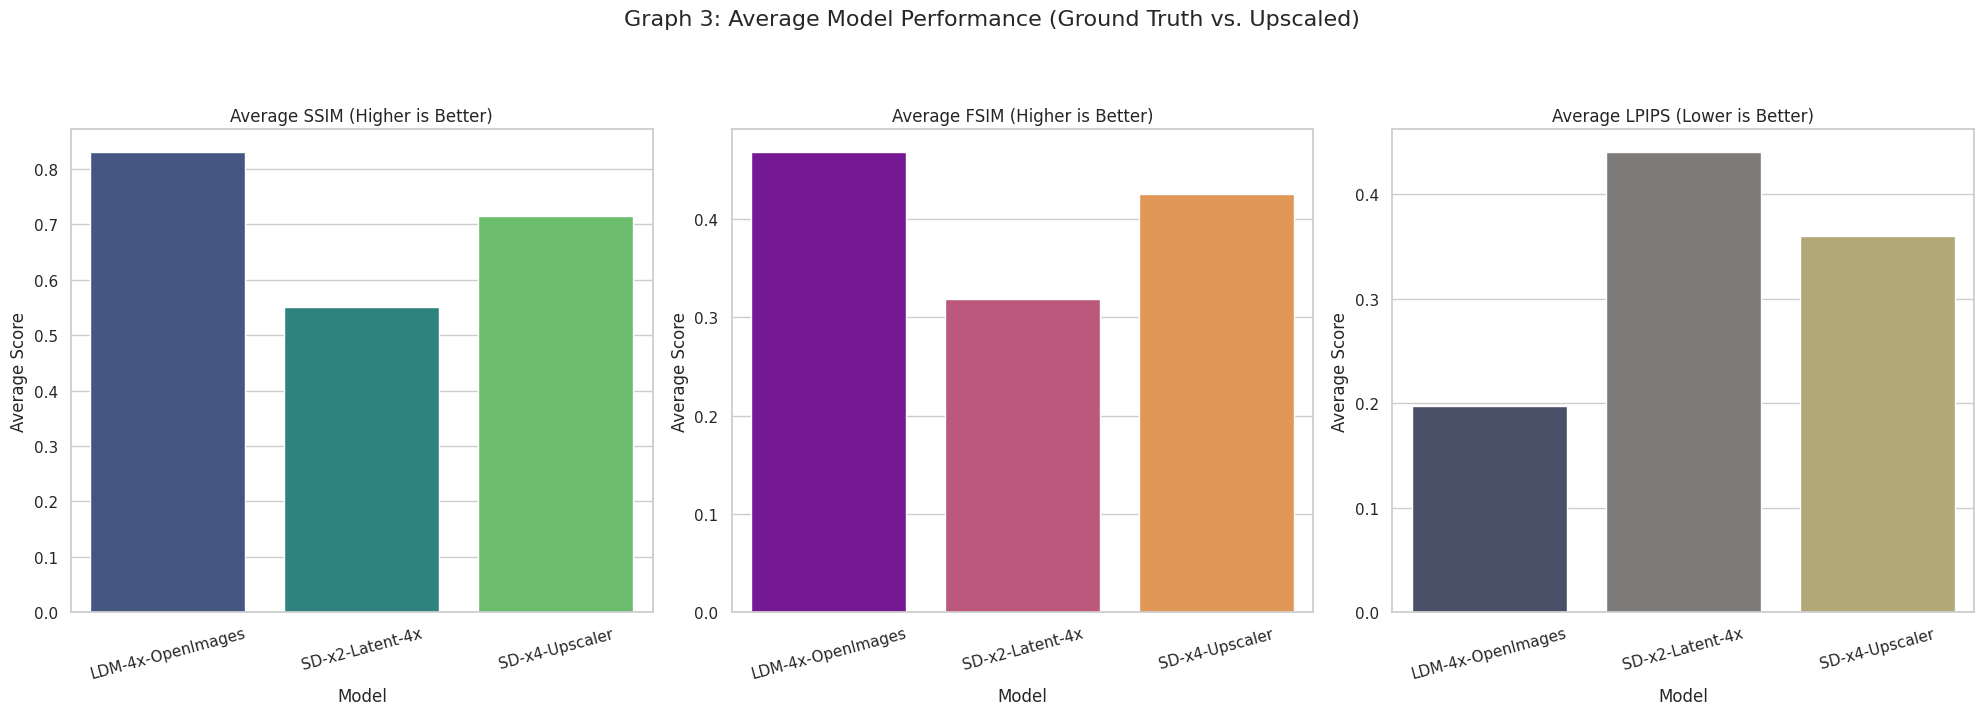

In [18]:
sns.set_theme(style="whitegrid")

# Load the dataframe
df = pd.read_csv('benchmark_results_COMBINED.csv')

# Get the unique model names
model_names = df['model_name'].unique()


# dataframe
df_low_res_melted = df.melt(id_vars=['model_name', 'pixels'],
                           value_vars=['ssim_low_res_vs_upscaled',
                                       'fsim_low_res_vs_upscaled',
                                       'lpips_low_res_vs_upscaled'],
                           var_name='metric', value_name='score')

g1 = sns.FacetGrid(df_low_res_melted, col="model_name", hue="metric",
                   col_wrap=3, sharex=True, sharey=False,
                   height=5, aspect=1.2)

# Map the lineplot and scatterplot to the grid
g1.map(sns.lineplot, "pixels", "score", marker="o")
g1.map(sns.scatterplot, "pixels", "score")
g1.set_titles(col_template="{col_name}")
g1.set_axis_labels("Pixels", "Score")
g1.add_legend(title="Metric")
g1.fig.suptitle('Graph 1: "Low Res vs. Upscaled" Metrics per Model', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()
#plt.close(g1.fig) 

# dataframe
df_gt_melted = df.melt(id_vars=['model_name', 'pixels'],
                       value_vars=['ssim_ground_truth_vs_upscaled',
                                   'fsim_ground_truth_vs_upscaled',
                                   'lpips_ground_truth_vs_upscaled'],
                       var_name='metric', value_name='score')

# Create a FacetGrid
g2 = sns.FacetGrid(df_gt_melted, col="model_name", hue="metric",
                   col_wrap=3, sharex=True, sharey=False,
                   height=5, aspect=1.2)

g2.map(sns.lineplot, "pixels", "score", marker="o")
g2.map(sns.scatterplot, "pixels", "score")
g2.set_titles(col_template="{col_name}")
g2.set_axis_labels("Pixels", "Score")
g2.add_legend(title="Metric")
g2.fig.suptitle('Graph 2: "Ground Truth vs. Upscaled" Metrics per Model', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()
#plt.close(g2.fig)


df_avg = df.groupby('model_name')[[
    'ssim_ground_truth_vs_upscaled',
    'fsim_ground_truth_vs_upscaled',
    'lpips_ground_truth_vs_upscaled'
]].mean().reset_index()

# Create a 1x3 subplot figure
fig3, axes3 = plt.subplots(1, 3, figsize=(20, 7))
fig3.suptitle('Graph 3: Average Model Performance (Ground Truth vs. Upscaled)', fontsize=16, y=1.02)

# Subplot 1: Average SSIM
sns.barplot(data=df_avg, x='model_name', y='ssim_ground_truth_vs_upscaled', ax=axes3[0], palette='viridis')
axes3[0].set_title('Average SSIM (Higher is Better)')
axes3[0].set_ylabel('Average Score')
axes3[0].set_xlabel('Model')
axes3[0].tick_params(axis='x', rotation=15)

# Subplot 2: Average FSIM
sns.barplot(data=df_avg, x='model_name', y='fsim_ground_truth_vs_upscaled', ax=axes3[1], palette='plasma')
axes3[1].set_title('Average FSIM (Higher is Better)')
axes3[1].set_ylabel('Average Score')
axes3[1].set_xlabel('Model')
axes3[1].tick_params(axis='x', rotation=15)

# Subplot 3: Average LPIPS
sns.barplot(data=df_avg, x='model_name', y='lpips_ground_truth_vs_upscaled', ax=axes3[2], palette='cividis')
axes3[2].set_title('Average LPIPS (Lower is Better)')
axes3[2].set_ylabel('Average Score')
axes3[2].set_xlabel('Model')
axes3[2].tick_params(axis='x', rotation=15)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
#plt.close(fig3)

This cell calculates the overall standard deviation for each of the three models, providing a key measure of their consistency.

First, it defines the metric_columns to be analyzed. It then groups the main DataFrame by model_name (collapsing all the different resolution tests) and calculates the standard deviation (.std()) for each metric. This operation reveals how much a model's scores varied across all its tests, with a lower number indicating higher consistency.

Finally, the columns are renamed (e.g., adding a _std_dev suffix) and the resulting DataFrame is displayed, showing a single row of SD values for each model.

In [19]:

metric_columns = [
    'ssim_low_res_vs_upscaled',
    'fsim_low_res_vs_upscaled',
    'lpips_low_res_vs_upscaled',
    'ssim_ground_truth_vs_upscaled',
    'fsim_ground_truth_vs_upscaled',
    'lpips_ground_truth_vs_upscaled'
]

df_model_std_dev = df.groupby('model_name')[metric_columns].std().reset_index()

std_dev_column_names = {col: f'{col}_std_dev' for col in metric_columns}
df_model_std_dev = df_model_std_dev.rename(columns=std_dev_column_names)

df_model_std_dev.head()

,model_name,ssim_low_res_vs_upscaled_std_dev,fsim_low_res_vs_upscaled_std_dev,lpips_low_res_vs_upscaled_std_dev,ssim_ground_truth_vs_upscaled_std_dev,fsim_ground_truth_vs_upscaled_std_dev,lpips_ground_truth_vs_upscaled_std_dev
0,LDM-4x-OpenImages,0.010623,0.020706,0.018227,0.006081,0.021942,0.020116
1,SD-x2-Latent-4x,0.061957,0.026974,0.027335,0.063273,0.023971,0.029710
2,SD-x4-Upscaler,0.018281,0.049183,0.031705,0.017226,0.037746,0.027972


## Conclusion
After running all the tests on this new satellite dataset, it's clear there’s no single "best" model, but there's a fascinating story in the trade-offs.

The real surprise contender, and arguably the most impressive, was the LDM-4x-OpenImages model. What's remarkable is that this model is "unguided"—it doesn't use any text prompts. Yet, it gave the top-tier Stable Diffusion models a serious run for their money. It delivered a fantastic balance of high-quality scores and a decent processing time, making it a powerful and straightforward "all-rounder."

The SD-x4-Upscaler was the champion in terms of raw, on-paper accuracy. It won both the SSIM and FSIM scores and was by far the most consistent (with the lowest standard deviation). If you need the most mathematically precise and reliable image, this is the one. The catch? It's slow, and it relies on a well-engineered prompt to even get those results—something the LDM model didn't need at all.

Finally, the SD-x2-Latent-4x was the "speed demon" of the group. It was the fastest by a mile and actually won the LPIPS score, meaning its images had a high perceptual quality (they just looked good to the human eye). This speed came at a cost, though; its results were the most inconsistent, with scores varying significantly between runs.

So, the final choice really depends on the job.

For a simple, "fire-and-forget" option that delivers high-quality, balanced results, the LDM model looks like the strongest pick.

If you need absolute scientific accuracy and are willing to wait for it, the SD-x4-Upscaler is your tool.

And if you just need an image that looks good fast, you'd go with the SD-x2-Latent-4x.